<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
Applied ML · MLOps · Production
<br>
Join 30K+ developers in learning how to responsibly <a href="https://madewithml.com/about/">deliver value</a> with ML.
    <br>
</div>

<br>

<div align="center">
    <a target="_blank" href="https://madewithml.com"><img src="https://img.shields.io/badge/Subscribe-30K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/GokuMohandas/Made-With-ML"><img src="https://img.shields.io/github/stars/GokuMohandas/Made-With-ML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/goku"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/GokuMohandas"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/topics/deep-learning" target="_blank">top ML</a> repositories on GitHub
</div>

<br>
<hr>

# Utilities
In this lesson, we will explore utilities to extend and simplify training.

<div align="left">
<a target="_blank" href="https://madewithml.com/courses/foundations/utilities/"><img src="https://img.shields.io/badge/📖 Read-blog post-9cf"></a>&nbsp;
<a href="https://github.com/GokuMohandas/Made-With-ML/blob/main/notebooks/10_Utilities.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/GokuMohandas/Made-With-ML/blob/main/notebooks/10_Utilities.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# Set up

We're having to set a lot of seeds for reproducibility now, so let's wrap it all up in a function.

In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn

In [ ]:
SEED = 1234

In [ ]:
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

In [ ]:
# Set seeds for reproducibility
set_seeds(seed=SEED)

In [ ]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cuda


## Load data

We'll use the same spiral dataset from previous lessons to demonstrate our utilities.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/spiral.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,X1,X2,color
0,0.106737,0.114197,c1
1,0.311513,-0.664028,c1
2,0.019870,-0.703126,c1
3,-0.054017,0.508159,c3
4,-0.127751,-0.011382,c3


In [ ]:
# Data shapes
X = df[["X1", "X2"]].values
y = df["color"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1500, 2)
y:  (1500,)


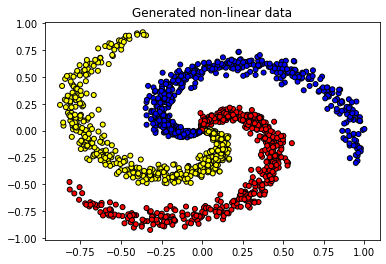

In [ ]:
# Visualize data
plt.title("Generated non-linear data")
colors = {"c1": "red", "c2": "yellow", "c3": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors="k", s=25)
plt.show()

## Split data

In [ ]:
import collections
from sklearn.model_selection import train_test_split

In [ ]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [ ]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (1050, 2), y_train: (1050,)
X_val: (225, 2), y_val: (225,)
X_test: (225, 2), y_test: (225,)
Sample point: [-0.63919105 -0.69724176] → c1


## LabelEncoder

Next we'll define a `LabelEncoder` to encode our text labels into unique indices. We're not going to use scikit-learn's LabelEncoder anymore because we want to be able to save and load our instances the way we want to. 

In [ ]:
import itertools

In [ ]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.class_to_index

{"c1": 0, "c2": 1, "c3": 2}

In [ ]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: c1
y_train[0]: 0


In [ ]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [350 350 350]
weights: {0: 0.002857142857142857, 1: 0.002857142857142857, 2: 0.002857142857142857}


## StandardScaler

We need to standardize our data (zero mean and unit variance) so a specific feature's magnitude doesn't affect how the model learns its weights. We're only going to standardize the inputs X because our outputs y are class values. We're going to compose our own `StandardScaler` class so we can easily save and load it later during inference.

In [ ]:
class StandardScaler(object):
    def __init__(self, mean=None, std=None):
        self.mean = np.array(mean)
        self.std = np.array(std)

    def fit(self, X):
        self.mean =  np.mean(X_train, axis=0)
        self.std = np.std(X_train, axis=0)

    def scale(self, X):
        return (X - self.mean) / self.std

    def unscale(self, X):
        return (X * self.std) + self.mean

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'mean': self.mean.tolist(), 'std': self.std.tolist()}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler()
X_scaler.fit(X_train)

In [ ]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.scale(X_train)
X_val = X_scaler.scale(X_val)
X_test = X_scaler.scale(X_test)

In [ ]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: 0.1, std: 0.9
X_test[1]: mean: 0.0, std: 1.0


# DataLoader

We're going to place our data into a [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and use a [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to efficiently create batches for training and evaluation.

In [ ]:
import torch

In [ ]:
# Seed seed for reproducibility
torch.manual_seed(SEED)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch, dtype=object)
        X = np.stack(batch[:, 0], axis=0)
        y = np.stack(batch[:, 1], axis=0)

        # Cast
        X = torch.FloatTensor(X.astype(np.float32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True)

We don't really need the `collate_fn` here but we wanted to make it transparent because we will need it when we want to do specific processing on our batch (ex. padding). We'll be using a custom collate function in the next lesson.

In [ ]:
# Create datasets
train_dataset = Dataset(X=X_train, y=y_train)
val_dataset = Dataset(X=X_val, y=y_val)
test_dataset = Dataset(X=X_test, y=y_test)
print ("Datasets:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  y: {train_dataset[0][1]}")

Datasets:
  Train dataset:<Dataset(N=1050)>
  Val dataset: <Dataset(N=225)>
  Test dataset: <Dataset(N=225)>
Sample point:
  X: [-1.47355106 -1.67417243]
  y: 0


So far, we used batch gradient descent to update our weights. This means that we calculated the gradients using the entire training dataset. We also could've updated our weights using stochastic gradient descent (SGD) where we pass in one training example one at a time. The current standard is mini-batch gradient descent, which strikes a balance between batch and stochastic GD, where we update the weights using a mini-batch of n (`BATCH_SIZE`) samples. This is where the `DataLoader` object comes in handy.

In [ ]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")

Sample batch:
  X: [64, 2]
  y: [64]
Sample point:
  X: tensor([-1.4736, -1.6742])
  y: 0


# Device

So far we've been running our operations on the CPU but when we have large datasets and larger models to train, we can benefit by parallelizing tensor operations on a GPU. In this notebook, you can use a GPU by going to `Runtime` > `Change runtime type` > Select `GPU` in the `Hardware accelerator` dropdown. We can what device we're using with the following line of code:

In [ ]:
# Set CUDA seeds
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) # multi-GPU

In [ ]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cuda


# Model

Let's initialize the model we'll be using to show the capabilities of training utilities.

In [ ]:
import math
from torch import nn
import torch.nn.functional as F

In [ ]:
INPUT_DIM = X_train.shape[1] # 2D
HIDDEN_DIM = 100
DROPOUT_P = 0.1
NUM_CLASSES = len(label_encoder.classes)
NUM_EPOCHS = 10

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_p, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, inputs):
        x_in, = inputs
        z = F.relu(self.fc1(x_in))
        z = self.dropout(z)
        z = self.fc2(z)
        return z

In [ ]:
# Initialize model
model = MLP(
    input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, 
    dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)>


# Trainer

So far we've been writing training loops that train only using the train data split and then we perform evaluation on our test set. But in reality, we would follow this process:

1. Train using mini-batches on one epoch of the train data split.
2. Evaluate loss on the validation split and use it to adjust hyperparameters (ex. learning rate).
3. After training ends (via stagnation in improvements, desired performance, etc.), evaluate your trained model on the test (hold-out) data split.

We'll create a `Trainer` class to keep all of these processes organized.

The first function in the class is `train_step` which will train the model using batches from one epoch of the train data split.

```python
def train_step(self, dataloader):
    """Train step."""
    # Set model to train mode
    self.model.train()
    loss = 0.0

    # Iterate over train batches
    for i, batch in enumerate(dataloader):

        # Step
        batch = [item.to(self.device) for item in batch]  # Set device
        inputs, targets = batch[:-1], batch[-1]
        self.optimizer.zero_grad()  # Reset gradients
        z = self.model(inputs)  # Forward pass
        J = self.loss_fn(z, targets)  # Define loss
        J.backward()  # Backward pass
        self.optimizer.step()  # Update weights

        # Cumulative Metrics
        loss += (J.detach().item() - loss) / (i + 1)

    return loss
```

Next we'll define the `eval_step` which will be used for processing both the validation and test data splits. This is because neither of them require gradient updates and display the same metrics.

```python
def eval_step(self, dataloader):
    """Validation or test step."""
    # Set model to eval mode
    self.model.eval()
    loss = 0.0
    y_trues, y_probs = [], []

    # Iterate over val batches
    with torch.inference_mode():
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, y_true = batch[:-1], batch[-1]
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, y_true).item()

            # Cumulative Metrics
            loss += (J - loss) / (i + 1)

            # Store outputs
            y_prob = F.softmax(z).cpu().numpy()
            y_probs.extend(y_prob)
            y_trues.extend(y_true.cpu().numpy())

    return loss, np.vstack(y_trues), np.vstack(y_probs)
```

The final function is the `predict_step` which will be used for inference. It's fairly similar to the `eval_step` except we don't calculate any metrics. We pass on the predictions which we can use to generate our performance report.

```python
def predict_step(self, dataloader):
    """Prediction step."""
    # Set model to eval mode
    self.model.eval()
    y_probs = []

    # Iterate over val batches
    with torch.inference_mode():
        for i, batch in enumerate(dataloader):

            # Forward pass w/ inputs
            inputs, targets = batch[:-1], batch[-1]
            z = self.model(inputs)

            # Store outputs
            y_prob = F.softmax(z).cpu().numpy()
            y_probs.extend(y_prob)

    return np.vstack(y_probs)
```

# LR Scheduler

As our model starts to optimize and perform better, the loss will reduce and we'll need to make smaller adjustments. If we keep using a fixed learning rate, we'll be overshooting back and forth. Therefore, we're going to add a learning rate scheduler to our optimizer to adjust our learning rate during training. There are many [schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) schedulers to choose from but a popular one is `ReduceLROnPlateau` which reduces the learning rate when a metric (ex. validation loss) stops improving. In the example below we'll reduce the learning rate by a factor of 0.1 (`factor=0.1`) when our metric of interest (`self.scheduler.step(val_loss)`) stops decreasing (`mode="min"`) for three (`patience=3`) straight epochs.

```python
# Initialize the LR scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)
...
train_loop():
    ...
    # Steps
    train_loss = trainer.train_step(dataloader=train_dataloader)
    val_loss, _, _ = trainer.eval_step(dataloader=val_dataloader)
    self.scheduler.step(val_loss)
    ...
```

# Early Stopping

We should never train our models for an arbitrary number of epochs but instead we should have explicit stopping criteria (even if you are bootstrapped by compute resources). Common stopping criteria include when validation performance stagnates for certain # of epochs (`patience`), desired performance is reached, etc.

```python
# Early stopping
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = trainer.model
    _patience = patience  # reset _patience
else:
    _patience -= 1
if not _patience:  # 0
    print("Stopping early!")
    break
```

# Training

Let's put all of this together now to train our model.

In [ ]:
from torch.optim import Adam

In [ ]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 100
PATIENCE = 3

In [ ]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)

In [ ]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = F.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                z = self.model(inputs)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)

        return np.vstack(y_probs)

    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn, 
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.73999, val_loss: 0.58441, lr: 1.00E-02, _patience: 3
Epoch: 2 | train_loss: 0.52631, val_loss: 0.41542, lr: 1.00E-02, _patience: 3
Epoch: 3 | train_loss: 0.40919, val_loss: 0.30673, lr: 1.00E-02, _patience: 3
Epoch: 4 | train_loss: 0.31421, val_loss: 0.22428, lr: 1.00E-02, _patience: 3
Epoch: 5 | train_loss: 0.25295, val_loss: 0.17446, lr: 1.00E-02, _patience: 3
Epoch: 6 | train_loss: 0.22243, val_loss: 0.14668, lr: 1.00E-02, _patience: 3
Epoch: 7 | train_loss: 0.18416, val_loss: 0.12333, lr: 1.00E-02, _patience: 3
Epoch: 8 | train_loss: 0.16403, val_loss: 0.10400, lr: 1.00E-02, _patience: 3
Epoch: 9 | train_loss: 0.15296, val_loss: 0.09289, lr: 1.00E-02, _patience: 3
Epoch: 10 | train_loss: 0.14347, val_loss: 0.08267, lr: 1.00E-02, _patience: 3
Epoch: 11 | train_loss: 0.13843, val_loss: 0.07776, lr: 1.00E-02, _patience: 3
Epoch: 12 | train_loss: 0.11476, val_loss: 0.06921, lr: 1.00E-02, _patience: 3
Epoch: 13 | train_loss: 0.10692, val_loss: 0.06558, lr: 1.00E

#Evaluation

In [ ]:
import json
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
def get_performance(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

In [ ]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [ ]:
# Determine performance
performance = get_performance(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

{
  "precision": 0.9956140350877193,
  "recall": 0.9955555555555556,
  "f1": 0.9955553580159119,
  "num_samples": 225.0
}


# Saving and loading

Many tutorials never show you how to save the components you created so you can load them for inference.

In [ ]:
from pathlib import Path

In [ ]:
# Save artifacts
dir = Path("mlp")
dir.mkdir(parents=True, exist_ok=True)
label_encoder.save(fp=Path(dir, "label_encoder.json"))
X_scaler.save(fp=Path(dir, "X_scaler.json"))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, 'performance.json'), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

In [ ]:
# Load artifacts
device = torch.device("cpu")
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
X_scaler = StandardScaler.load(fp=Path(dir, "X_scaler.json"))
model = MLP(
    input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, 
    dropout_p=DROPOUT_P, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device)

MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)

In [ ]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [ ]:
# Dataloader
sample = [[0.106737, 0.114197]] # c1
X = X_scaler.scale(sample)
y_filler = label_encoder.encode([label_encoder.classes[0]]*len(X))
dataset = Dataset(X=X, y=y_filler)
dataloader = dataset.create_dataloader(batch_size=batch_size)

In [ ]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.argmax(y_prob, axis=1)
label_encoder.decode(y_pred)

["c1"]

# Miscellaneous

There are lots of other utilities to cover as well such as:

- Tokenizers to convert text to sequence of indices
- Various encoders to represent our data
- Padding to ensure uniform data shapes
- Experiment tracking to visualize and keep track of all experiments
- Hyperparameter optimization to tune our parameters (hidden units, learning rate, etc.)
- and many more!

We'll explore these as we require them in future lessons including some in our [MLOps](https://madewithml.com/#mlops) course!

